In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from collections import Counter

import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from classifier import MnistClassifier

## Dataset setup

In [16]:
dataset = datasets.MNIST(root='./datasets', train=True, transform=transforms.ToTensor(), download=True)
dataset = dataset[:10000]
print(f"Dataset size: {len(dataset)}")
print(f"Input image shape: {dataset[0][0].shape}")

ValueError: only one element tensors can be converted to Python scalars

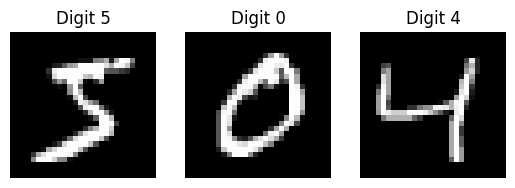

In [17]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(dataset[i][0].numpy().squeeze(), cmap="grey")
    plt.title(f"Digit {dataset[i][1]}")
    plt.axis("off")

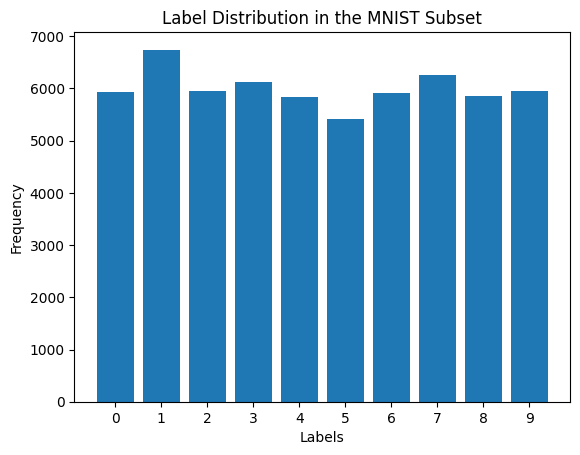

In [38]:
labels = [label for _, label in dataset]
label_counts = Counter(labels)

plt.bar(label_counts.keys(), label_counts.values())
plt.title("Label Distribution in the MNIST Subset")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(range(10))
plt.show()

## Train model

In [20]:
train_split_idx = len(dataset) * 3 // 4
train_ds, valid_ds = torch.utils.data.random_split(dataset, [train_split_idx, len(dataset) - train_split_idx])
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(valid_ds)}")

Train dataset size: 45000
Validation dataset size: 15000


In [21]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2048, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=2048, shuffle=False)
print(f"Train dataloader size: {len(train_dl)}")
print(f"Validation dataloader size: {len(valid_dl)}")

Train dataloader size: 22
Validation dataloader size: 8


In [22]:
epochs = 10
model = MnistClassifier(in_channels=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

metrics = []
for epoch in range(1, epochs + 1):
    # Training step
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for images, labels in tqdm.tqdm(train_dl, desc=f"Train epoch {epoch}: "):
        # Forward pass
        preds = model(images)
        loss = criterion(preds, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics logging
        train_loss += loss.item()
        total += labels.shape[0]
        _, predicted = torch.max(preds, dim=1)
        correct += (predicted == labels).sum(dim=0)
    
    train_loss /= len(train_dl)
    train_accuracy = correct / total
    
    # Validation step
    model.eval()
    valid_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in tqdm.tqdm(valid_dl, desc=f"Validation epoch {epoch}: "):
            images, labels = images, labels

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss /= len(valid_dl)
    valid_accuracy = correct / total
    
    # Log the metrics
    print(f"Epoch {epoch}\n{train_loss = :.4f}, {train_accuracy = :.2f}\n{valid_loss = :.4f}, {valid_accuracy = :.2f}")
    metrics.append({
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "valid_loss": valid_loss,
        "valid_accuracy": valid_accuracy,
    })

Validation epoch 1: 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]


Epoch 1
train_loss = 2.2947, train_accuracy = 0.10
valid_loss = 2.2724, valid_accuracy = 0.13


Validation epoch 2: 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


Epoch 2
train_loss = 2.1790, train_accuracy = 0.32
valid_loss = 1.9700, valid_accuracy = 0.54


Validation epoch 3: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]


Epoch 3
train_loss = 1.5181, train_accuracy = 0.62
valid_loss = 1.0299, valid_accuracy = 0.70


Validation epoch 4: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


Epoch 4
train_loss = 0.8794, train_accuracy = 0.72
valid_loss = 0.7693, valid_accuracy = 0.76


Validation epoch 5: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]


Epoch 5
train_loss = 0.7404, train_accuracy = 0.77
valid_loss = 0.6954, valid_accuracy = 0.79


Validation epoch 6: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Epoch 6
train_loss = 0.6817, train_accuracy = 0.79
valid_loss = 0.6500, valid_accuracy = 0.80


Validation epoch 7: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]


Epoch 7
train_loss = 0.6427, train_accuracy = 0.80
valid_loss = 0.6184, valid_accuracy = 0.81


Validation epoch 8: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


Epoch 8
train_loss = 0.6148, train_accuracy = 0.81
valid_loss = 0.5944, valid_accuracy = 0.82


Validation epoch 9: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


Epoch 9
train_loss = 0.5935, train_accuracy = 0.82
valid_loss = 0.5720, valid_accuracy = 0.83


Validation epoch 10: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

Epoch 10
train_loss = 0.5702, train_accuracy = 0.83
valid_loss = 0.5526, valid_accuracy = 0.83


In [24]:
torch.save(model.state_dict(), 'models/mnist_classifier.pth')

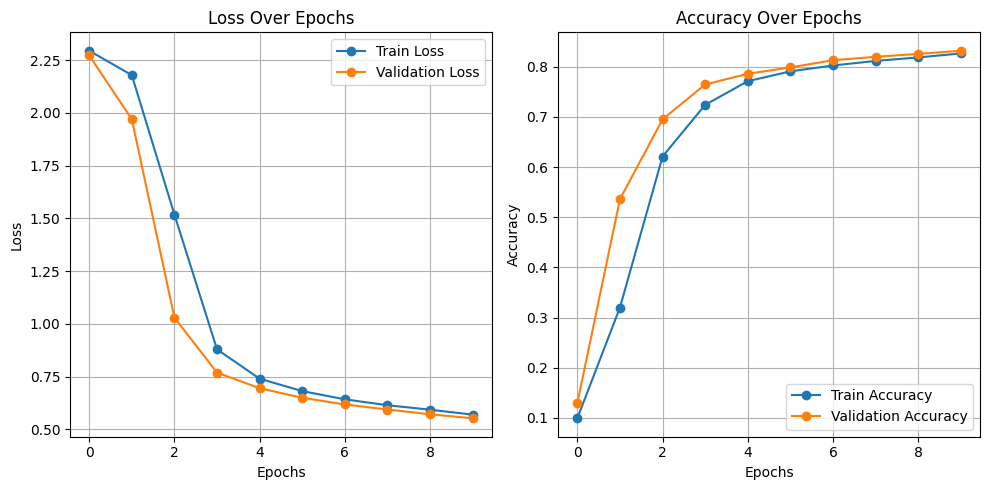

In [36]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), [m["train_loss"] for m in metrics], label="Train Loss", marker='o')
plt.plot(range(epochs), [m["valid_loss"] for m in metrics], label="Validation Loss", marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), [m["train_accuracy"] for m in metrics], label="Train Accuracy", marker='o')
plt.plot(range(epochs), [m["valid_accuracy"] for m in metrics], label="Validation Accuracy", marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()